# Taller de SMSB

## Análisis de Trayectorias

In [27]:
# Archivos en el directorio de trabajo
!ls

1fin                           analisis
4fkw                           funciones_auxiliares.ipynb
Analisis_de_trayectorias.ipynb


In [28]:
# Archivos en el directorio de trabajo
!ls 1fin/rep_1/

1_min                         sa_lig_1fin_CS262.rst7
2_term                        sa_lig_1fin_CS262_eq.mdinfo
3_eq                          sa_lig_1fin_CS262_prod.mdinfo
4_prod                        sa_lig_1fin_CS262_term.mdinfo
sa_lig_1fin_CS262.prmtop


## Propiedades del sistema

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2, style='ticks')
plt.rcParams['figure.figsize'] = (12.0, 6.0)

In [30]:
%run funciones_auxiliares.ipynb

### Minimización

In [31]:
# Path a los archivos .out de minimización de la conf 1fin
min_out_1fin_files = ['1fin/rep_1/1_min/sa_lig_1fin_CS262_min_solv.out', 
                      '1fin/rep_1/1_min/sa_lig_1fin_CS262_min_all.out']

In [32]:
# Es posible cargar cada archivo utilizando la función process_minout
df_min_1fin = [process_MIN_out(file) for file in min_out_1fin_files]
df_min_1fin = pd.concat(df_min_1fin, keys=['solv', 'all'])

# Actualiza el valor de los números de pasos
last_step_solv = df_min_1fin.loc['solv', 'NSTEP'].values[-1]
df_min_1fin.loc['all', 'NSTEP'] =  df_min_1fin.loc['all', 'NSTEP'].values + last_step_solv

df_min_1fin.tail()

NSTEP    ENERGY       RMS     GMAX   NUMBER
all 16  9199.0 -180500.0  0.057199   1.9172  21553.0
    17  9299.0 -180530.0  0.074982   2.9914   4586.0
    18  9399.0 -180550.0  0.206320  29.8120   3351.0
    19  9499.0 -180580.0  0.161020  19.4480   3351.0
    20  9587.0 -180600.0  0.049787   2.4167  18182.0

#### Visualización de la energía del sistema

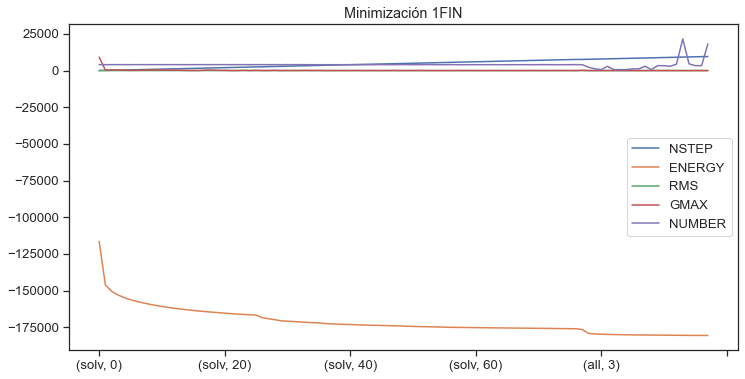

In [33]:
df_min_1fin.plot(title='Minimización 1FIN')
plt.show()

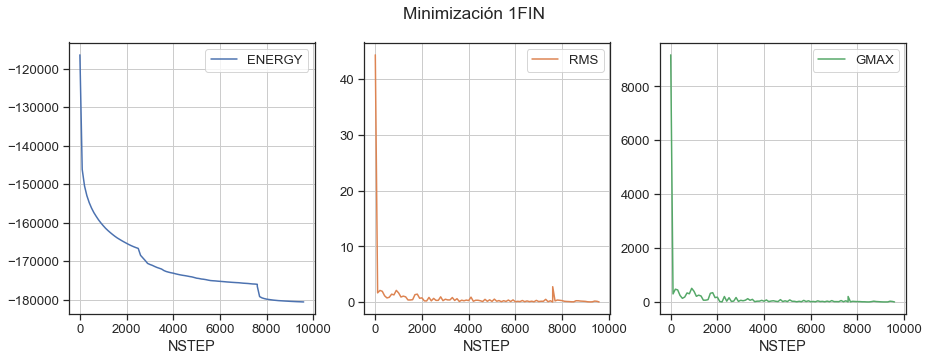

In [34]:
df_min_1fin[['NSTEP', 'ENERGY', 'RMS', 'GMAX']].\
    plot(x='NSTEP', title='Minimización 1FIN', subplots=True, 
         layout=(1, 3), figsize=(15, 5), grid=True)
plt.show()

In [35]:
# Compara el resultado con lo solicitado en el archivo de configuración
!cat 1fin/rep_1/1_min/min_all.in

Minimize all atoms, minimizacion del solvente
   System minimization:
&cntrl
   imin=1,
   ntmin=1,     ! metodo de minimizacion, 1 steepest decent to onjugate gradients
   nmropt=0,    ! no hacer el análisi NMR
   drms=0.05,    ! criterio de convergencia para el gradiente de energía
   maxcyc=50000, ! maximo numero de ciclos para la minimizacion
   ncyc=2500,   ! cuando ntmin=NCYC, indica el paso para cambiar de SD a CG
   ntx=1,       ! #para leerlas coordenadas iniciales, vel y boxsize del inpcrd. 1=para comenzar
   irest=0,     ! #Flag para reiniciar una simulacion; 0= no reiniciar 
   ntpr=100,    ! Intervalo de pasos para gardar informacion
   ntwr=100,    ! Intervalo de pasos para guardar un restart
   iwrap=0,     ! cuando =1, realiza un wrap en favor de la visualizacion de las mol dentro del box, no tiene efecto sobre la dinamica
   ntf=1,       ! Tipo de evaluacion de fuerzas, =1 calcula la interaccion total
   ntb=1,       ! Controla el tipo de simulacion y el PME; =1 NVT =2

### Fases de la dinámica

Carga de los archivos `.out`

In [36]:
dm_outs_1fin = [
    '1fin/rep_1/2_term/sa_lig_1fin_CS262_term.out',
    '1fin/rep_1/3_eq/sa_lig_1fin_CS262_eq.out',
    '1fin/rep_1/4_prod/sa_lig_1fin_CS262_prod.out'
]

df_md_1fin = pd.concat([process_MD_out(file) 
                        for file in dm_outs_1fin],
                        keys=('heat', 'eq', 'prod'))
df_md_1fin.columns

Index(['NSTEP', 'TIME', 'TEMP', 'PRESS', 'Etot', 'EKtot', 'EPtot', 'EELEC',
       'VDWAALS'],
      dtype='object')

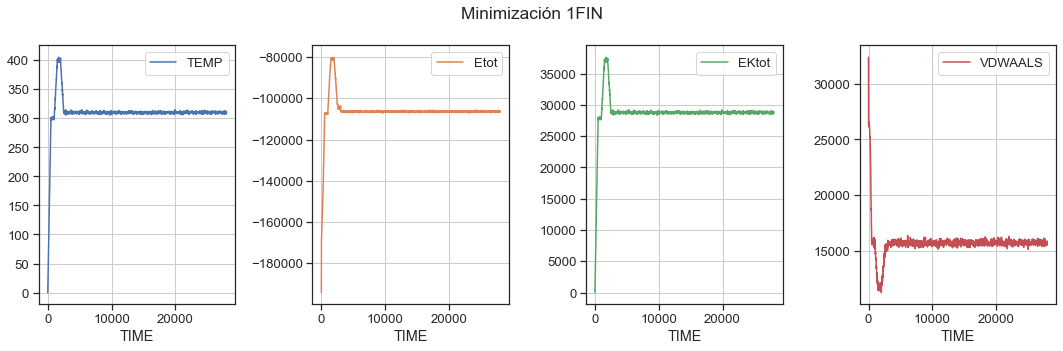

In [37]:

df_md_1fin[['TIME', 'TEMP', 'Etot', 'EKtot', 'VDWAALS']].\
    plot(x='TIME', title='Minimización 1FIN', subplots=True, 
         layout=(1, 4), figsize=(15, 5), grid=True)
plt.tight_layout()
plt.show()

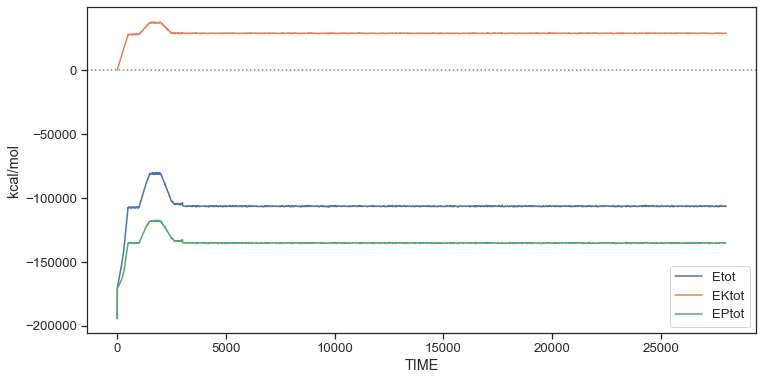

In [38]:
df_md_1fin[['TIME', 'Etot', 'EKtot', 'EPtot']]\
    .plot(x='TIME', ylabel='kcal/mol')
plt.axhline(0, c='gray', linestyle=':')
plt.show()

## Análisis de Trayectorias

In [39]:
import mdtraj as md
import pytraj as pyt

### Carga de la trayectoria
##### Estructura inicial del sistema
Cargamos la estructura inicial del sistema **1fin**, representado por los archivos:
  1. `sa_lig_1fin_CS262.rst7`
  2. `sa_lig_1fin_CS262.prmtop`

In [40]:
conf_inicial_1fin = pyt.load('1fin/rep_1/sa_lig_1fin_CS262.rst7',
                            top='1fin/rep_1/sa_lig_1fin_CS262.prmtop'
                            )
conf_inicial_1fin

pytraj.Trajectory, 1 frames: 
Size: 0.001017 (GB)
<Topology: 45482 atoms, 13830 residues, 13533 mols, PBC with box type = truncoct>
           

##### Trayectoria de la fase de producción

Carga del la trayectoria del sistema (fase de producción), almacenada en el archivo `sa_lig_1fin_CS262_prod.nc`.

In [41]:
traj_prod_1fin = pyt.load('1fin/rep_1/4_prod/sa_lig_1fin_CS262_prod.nc',
         top = '1fin/rep_1/sa_lig_1fin_CS262.prmtop'
        )

# El comando autoimage permite visualizar correctamente el sistema
traj_prod_1fin = traj_prod_1fin.autoimage()

### Visualización

#### Selección de los residuos de la cavidad

Usaremos la librería `get_pocket_residues` del la libreta `funciones_auxiliares` para obtener los residuos que pertenecen al *pocket* de la proteína.

In [231]:
import nglview as ng
# Superponer la trayectoria antes de visualizarla
traj_prod_1fin.superpose(f'@CA')
pocket_residues = '8, 9, 33, 64, 65, 79, 86, 88, 89, 90, 132, 145, 146'
pocket = traj_prod_1fin[f':{pocket_residues}']

view = ng.show_pytraj(traj_prod_1fin)
view.clear()
view.add_representation('cartoon', 'protein')
view.add_representation('licorice', 'LIG')
view.add_trajectory(pocket)
# view.add_representation('line', opacity=0.5)
view

NGLWidget(max_frame=999)

## Calculo de RMSD

Permite comparar 2 conformaciones de la misma molécula.

$$\begin{aligned}
RMSD(W, \hat W) & = RMSE  \\
& = \sqrt{\frac{SSE}{n}} \\
& = \sqrt{\frac{\sum_{i=1}^n (w_i - \hat w_i)^2}{n}} \\
& = \sqrt{\frac{1}{n}\sum_{i=1}^n ((w_{ix} - \hat w_{ix})^2 + (w_{iy} - \hat w_{iy})^2 + (w_{iz} - \hat w_{iz})^2)}
\end{aligned}
$$

donde:
- $RMSD$: *Root Mean Square Deviation* -> Raiz de la media del cuadrado de las "desviaciones"
- $\hat W$: Conformación de referencia (matriz de coordenadas: dims = $n\times3$)
- $w_i$: Vector de posiciones $x,y,z$ del átomo $i$
- $n$: Número de átomos
- $SSE$: *Sum of Squared Errors*

### Compara dos conformaciones con el RMSD

In [44]:
# Carga la conformacion inicial del pdbid 4fkw
conf_inicial_4fkw = pyt.load('4fkw/rep_1/cdk2_LIG.rst7',
                            top='4fkw/rep_1/cdk2_LIG.prmtop')
conf_inicial_4fkw

pytraj.Trajectory, 1 frames: 
Size: 0.000966 (GB)
<Topology: 43221 atoms, 13077 residues, 12780 mols, PBC with box type = truncoct>
           

#### Cálcula tú mismo el RMSD entre dos conformaciones
1. Los sistemas a comparar deben tener el mismo tipo de átomos.

In [45]:
# Selecciona sólo los carbonos alfa de las dos conformaciones
ca_init_1fin = conf_inicial_1fin['@CA'] 
ca_init_4fkw = conf_inicial_4fkw['@CA'] 
ca_init_4fkw # La proteína tiene 298 residuos, por lo tanto 298 CA

pytraj.Trajectory, 1 frames: 
Size: 0.000007 (GB)
<Topology: 298 atoms, 298 residues, 298 mols, PBC with box type = truncoct>
           

2. Obtención de las coordenadas de los átomos

In [46]:
W_1 = ca_init_1fin[0].xyz # El índice 0 extrae la conformación 0 (la única) 
W_2 = ca_init_4fkw[0].xyz # El índice 0 extrae la conformación 0 (la única) 

W_1.shape # Dimensiones de la matriz de coordenadas

(298, 3)

3. Cálculo, paso a paso del RMSD entre las conformaciones $W_1$ y $W_2$.

In [47]:
# Cálculo de n = numero de CA de la proteína
n = len(ca_init_1fin[0].xyz)

# Cálculo de las diferencias (distancias por atomo entre W_1 y W_1)
W_1 - W_2

# Eleva al cuadrado las diferencias
(W_1 - W_2)**2

# Suma el cuadrado de las diferencias (por coord y por átomo)
np.sum( (W_1 - W_2)**2 )

# Divide entre el número de átomos
np.sum( (W_1 - W_2)**2 ) / n

# Saca la raiz cuadrada
np.sqrt( np.sum( (W_1 - W_2)**2 ) / n )

27.47909632061001

#### Cálcula el RMSD usando `pytraj`

Ya no es necesario pasar directamente las cordenadas, sino los objetos "Trayectory"

In [48]:
?pyt.rmsd

In [49]:
pyt.rmsd(traj = ca_init_1fin, 
         ref = ca_init_4fkw, 
         nofit = True) 
# con no fit evitamos que superponga las estructuras, 
# más adelante sí será necesario hacerlo

array([27.47909632])

### RMSD de la trayectoria ( `1fin`) vs a una estructura de referencia

#### RMSD de la proteína

Implica calcular el RMSD de cada una de las conformaciones (frames) de la trayectoria contra una conformación de referencia en común.

In [50]:
# Cálculo teniendo como referencia la conformación inicial
# de la proteína (antes de la fase de minimización)
rmsd_1 = pyt.rmsd(
            traj = traj_prod_1fin, 
            mask ='@CA',
            ref = conf_inicial_1fin,
            ref_mask = '@CA',
            nofit = False,
            mass = True
        )

In [51]:
# Usando como referencia la primer conformación de la fase de producción
rmsd_2 = pyt.rmsd(
            traj = traj_prod_1fin, 
            mask = '@CA',
            ref = 0,
            ref_mask = '@CA',
            nofit = False,
            mass = True
        )

In [52]:
# rmsd_1 es un vector con los valores de RMSD de cada conformación 
print(len(rmsd_1))
rmsd_1

1000


array([1.66364801, 1.45756748, 1.34946426, ..., 1.86435219, 1.99252687,
       1.81671286])

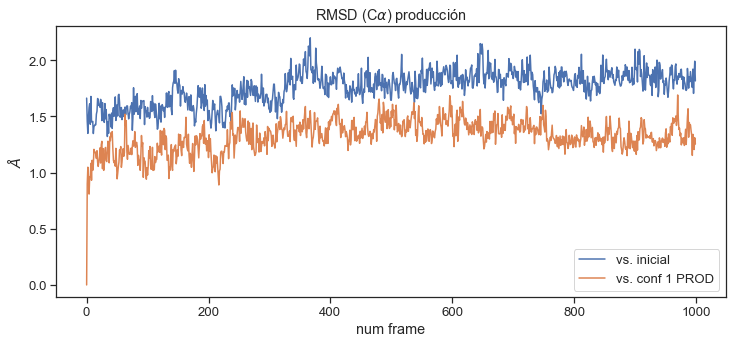

In [53]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(rmsd_1, label='vs. inicial')
ax.plot(rmsd_2, label='vs. conf 1 PROD')
ax.set(title=r'RMSD (C$\alpha$) producción', xlabel='num frame', ylabel=r'$\AA$')
ax.legend()
plt.show()

#### RMSD del ligando y la proteína

In [54]:
traj_prod_1fin.superpose('@CA')
rmsd_lig_1fin = pyt.rmsd(traj = traj_prod_1fin, 
                    ref = 0, 
                    nofit = True, 
                    # Evitamos el fit puesto que ya se ha hecho con .superpose
                    mask = ':LIG')

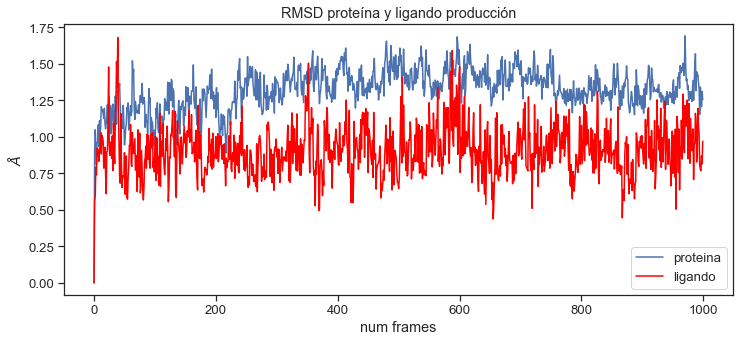

In [55]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(rmsd_2, label='proteina')
ax.plot(rmsd_lig_1fin, label='ligando', color='red')
ax.set(title='RMSD proteína y ligando producción', 
       xlabel='num frames', ylabel=r'$\AA$')
plt.legend()
plt.show()

#### RMSD del ligando y la proteína

In [81]:
# Cálculo del RMSD usando únicamente los átomos de la cavidad de la
# traj_prod_1fin.superpose(f'(@CA)&:{pocket_residues}')
rmsd_pocket = pyt.rmsd(
                traj = traj_prod_1fin, 
                ref = 0, 
                mask = f':{pocket_residues}&@CA'
            )

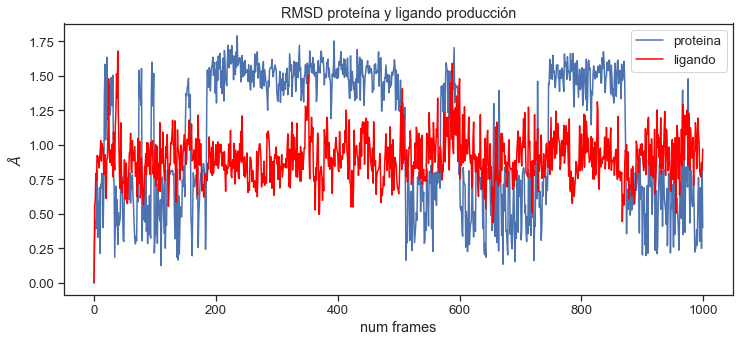

In [82]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(rmsd_pocket, label='proteina')
ax.plot(rmsd_lig_1fin, label='ligando', color='red')
ax.set(title='RMSD proteína y ligando producción', 
       xlabel='num frames', ylabel=r'$\AA$')
plt.legend()
plt.show()

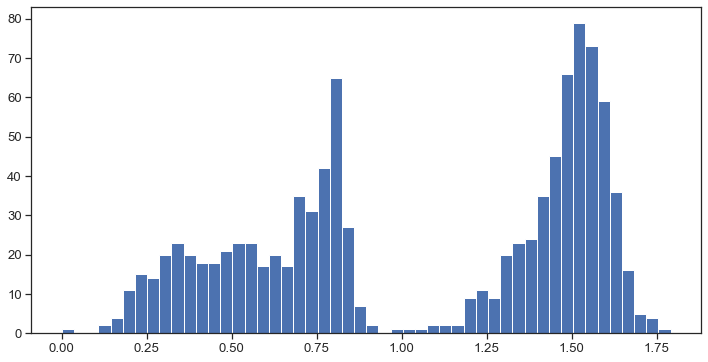

In [83]:
plt.hist(rmsd_pocket, bins=50)
plt.show()

### RMSD por pares de conformaciones

In [73]:
%%time
rmsd_pairwise_1fin = pyt.pairwise_rmsd(
    traj=traj_prod_1fin,
    mask=f'@CA,CB,CD',
    metric='rms'
)

CPU times: user 6.09 s, sys: 252 ms, total: 6.34 s
Wall time: 6.11 s


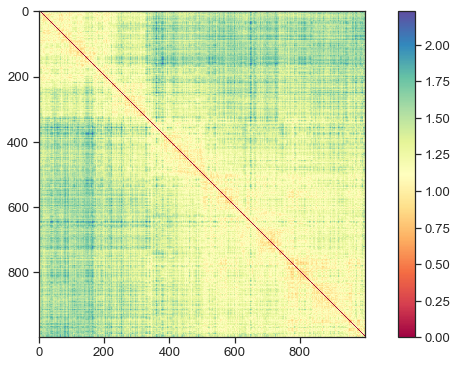

In [88]:
plt.imshow(rmsd_pairwise_1fin, cmap='Spectral', 
           interpolation='nearest')
plt.colorbar()
plt.show()

### RMSF

Es equivalente a la desviación estándar de la posición de un átomo $i$ con respecto a la media  de su posición ($\bar w^{(i)}$) en toda la trayectoria (compuesta por $T$ frames - conformaciones). 

$$\begin{aligned}
RMSF^{(i)} & = \sqrt{\frac{1}{T}\sum_{i=1}^T (w_j^{(i)} - \bar w^{(i)})^2} 
\end{aligned}
$$

donde:
- $RMSF^{(i)}$: *Root Mean Square Fluctuation* del átomo $i$ -> Raiz de la media del cuadrado de las "fluctuaciones"
- $w_j^{(i)}$: Vector de posiciones $x,y,z$ del átomo $i$ en el frame $j$
- $\bar w^{(i)}$: Vector con la media de las posiciones $x,y,z$ del átomo $i$ en toda la trayectoria.
- $T$: Número de frames de la trayectoria


##### Cálculo "Manual" del RMSF

In [263]:
# Extrae las coordenadas de los carbonos alfa de toda la trayectoria
ca_traj_1fin_coords = traj_prod_1fin['@CA'].xyz
# Visualiza las dimensiones de la matriz
ca_traj_1fin_coords.shape

# Calcula T: Primera dimension del arreglo
T = ca_traj_1fin_coords.shape[0]

# Todo el proceso junto (examinalo de adrentro hacia afuera)

# Raiz cuadrada
np.sqrt(
    # Suma entre todas los frames
    np.sum(
        # Suma de los tres ejes
        np.sum(
            # Cuadrado de las diferencias con respecto a la media
            ( ca_traj_1fin_coords - ca_traj_1fin_coords.mean(axis=0) )**2, 
        axis=0),
     axis=1) / T # Divide entre el número de frames
)

array([3.86753026, 1.70613974, 1.3391033 , ..., 1.54451939, 2.03697136,
       2.69237316])

#### RMSF con pytraj

In [199]:
traj_prod_1fin.superpose('@CA')
rmsf_ca_prot_1fin = pyt.rmsf(traj=traj_prod_1fin, mask='@CA')

# Hay tantos valores de RMSF como C-alfa tiene la proteína
len(rmsf_ca_prot)

298

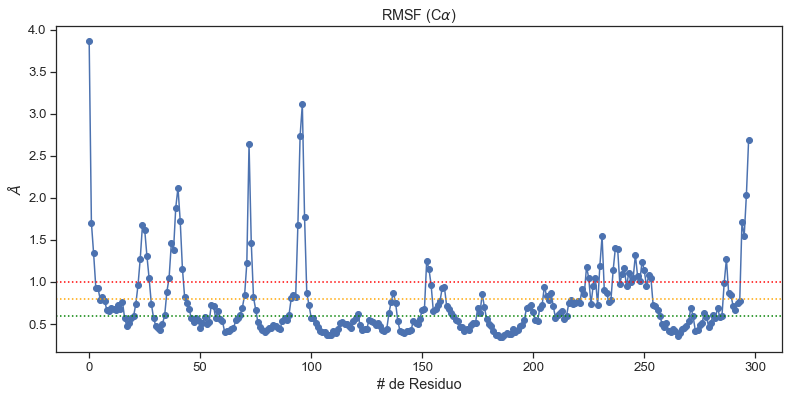

In [215]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(rmsf_ca_prot_1fin[:,1], 'o-')
ax.set(title=r'RMSF (C$\alpha$)', ylabel=r'$\AA$', xlabel='# de Residuo')
ax.axhline(y=0.6, color='green', linestyle=':')
ax.axhline(y=0.8, color='orange', linestyle=':')
ax.axhline(y=1, color='red', linestyle=':')
plt.show()

In [222]:
res_rmsf_up_05 = (np.where(rmsf_ca_prot_1fin[:,1] > .6)[0] + 1).tolist()
res_rmsf_up_08 = (np.where(rmsf_ca_prot_1fin[:,1] > 0.8)[0] + 1).tolist()
res_rmsf_up_1 = (np.where(rmsf_ca_prot_1fin[:,1] > 1.)[0] + 1).tolist()

#### Visualiza los residuos con mayor valor de RMSF

In [182]:
traj_prod_1fin.superpose(f'@CA')
# Conser
view = ng.show_pytraj(traj_prod_1fin['!(:WAT)'])
view.clear()
view.center()
view.add_representation('licorice', 'LIG')
view.add_cartoon(selection='protein', color='blue')
view.add_cartoon(selection='%s' % res_rmsf_up_05, color='green')
view.add_cartoon(selection='%s' % res_rmsf_up_08, color='orange')
view.add_cartoon(selection='%s' % res_rmsf_up_1, color='red')
view

NGLWidget(max_frame=999)

### RMSF: Compara 1fin vs 4fkw

Cargar los datos de la simulación `4fkw`.

In [206]:
# Carga la trayectoria de la proteína 4fkw
traj_prod_4fkw = pyt.load('4fkw/rep_1/4_prod/cdk2_LIG_prod.nc',
         top = '4fkw/rep_1/cdk2_LIG.prmtop'
        )
traj_prod_4fkw = traj_prod_4fkw.autoimage()

Calcula el RMSF de la trayectoria 4fkw.

In [207]:
traj_prod_4fkw.superpose('@CA')
rmsf_ca_prot_4fkw = pyt.rmsf(traj=traj_prod_4fkw, mask='@CA')

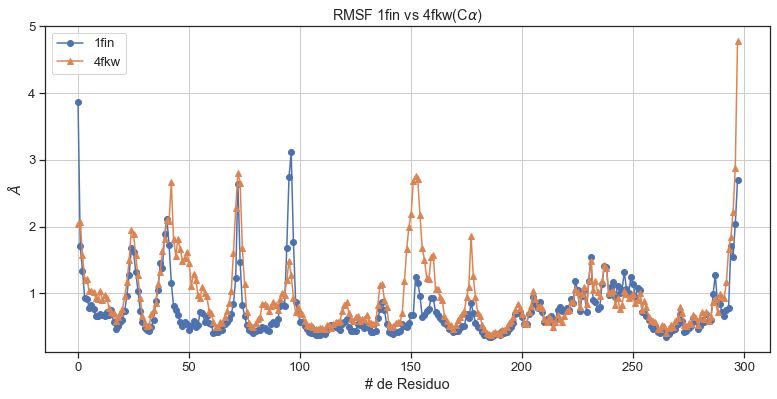

In [217]:
fig, ax = plt.subplots(figsize=(13, 6))
# Sistema 1fin
ax.plot(rmsf_ca_prot_1fin[:,1], 'o-', label='1fin')
# Sistema 4fkw 
ax.plot(rmsf_ca_prot_4fkw[:,1], '^-', label='4fkw')
ax.set(title=r'RMSF 1fin vs 4fkw(C$\alpha$)', 
       ylabel=r'$\AA$', xlabel='# de Residuo')
ax.legend()
ax.grid()
plt.show()

### Radio de giro


$$Rg = \sqrt{\frac{\sum_{i=1}^n m_i r_i^2}{\sum_{i=1}^n m_i}}$$



In [190]:
pyt.radgyr(traj=conf_inicial_1fin)

array([38.40400017])

In [41]:
## Hbond

In [42]:
?pyt.analysis.hbond_analysis.hbond

In [114]:
traj_md = md.load('1fin/rep_1/4_prod/sa_lig_1fin_CS262_prod.nc',
          top = '1fin/rep_1/sa_lig_1fin_CS262.prmtop'
         )

In [116]:
prot_ca = traj_md.topology.select('name CA')

rmsf_md = md.rmsf(traj_md[prot_ca])

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(rmsf_md, 'o-')
plt.show()

SyntaxError: unexpected EOF while parsing (<unknown>, line 1)

In [76]:
?md.rmsf

In [3]:
ligand = traj.topology.select('resname LIG') 
protein = traj.topology.select("protein")

NameError: name 'traj' is not defined

In [497]:
n_frames = len(traj)

In [499]:
# We want to create a dictionary containing every frame and the ligand hbonds which occur in that frame
Frame2hbond = {}
for frame in range(n_frames):
    # The dictionary "words" are the frame number
    Frame2hbond[frame] = [] 
    # We are doing the hbond analysis frame by frame
    hbonds = pyt.baker_hubbard(traj[frame]) 
    hbonds_each_frame.append(hbonds)
    # We only care about the hbonds if they involve the ligand 
    for hbond in hbonds:
        if ((hbond[0] in ligand) and (hbond[2] in protein) or #This is when the ligand is donating 
            (hbond[2] in ligand) and (hbond[0] in protein)): #This is when the ligand is accepting             
            all_hbonds_set.add(tuple(hbond))
            # The dictionary "definitions" are all the hbonds in that frame
            Frame2hbond[frame].append(tuple(hbond))  



AttributeError: module 'pytraj' has no attribute 'baker_hubbard'

In [9]:
!conda install -c ambermd pytraj -y

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: | 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
                                                                               failed

UnsatisfiableError: The following specifications were found
to be incompatible with the existing python installation in your environment:

Specifications:

  - pytraj -> python[version='2.7.*|3.4.*|3.5.*|3.6.*|>=2.7,<2.8.0a0|>=3.5,<3.6.0a0|>=3.6,<3.7.0a0|>=3.7,<3.8.0a0|>=3.8,<3.9.0a0']

Your python: python=3.9

If python is on the left-most side of the chain, that's the version you've asked for.
When python appears to the right, that indicates that the thing on the left is somehow
not available for 

In [190]:
!pip install prody

     |████████████████████████████████| 6.3 MB 289 kB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.2 MB 1.2 MB/s eta 0:00:01
  Created wheel for prody: filename=ProDy-2.0-cp37-cp37m-macosx_10_15_x86_64.whl size=6469449 sha256=0f1e9ab10a27acfabb79479b754283b16f2592993cd5686e5fb70e95ff8f70d0
  Stored in directory: /Users/joelricci/Library/Caches/pip/wheels/9f/cf/98/0221960cde47f24d8bd8be2ad62ba20b4c151b6e1dd8e27e82
Successfully built prody


In [191]:
from prody import *